<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C8/C8.html"><img src="../data/C8_nav.png" width="100"  style="float:right;" alt="C8"></a>
<h1>Signal Reconstruction</h1> 
</div>

<br/>

<p>   
Following Section 8.1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we cover in this notebook the important problem of reconstructing a discrete-time signal from a modified STFT. For further details, we refer to the classical article by Griffin and Lim. 

<ul>
<li><span style="color:black">
Daniel W. Griffin and Jae S. Lim: <strong>Signal estimation from modified short-time Fourier transform.</strong> IEEE Transactions on Acoustics, Speech, and Signal Processing,  32 (1984), pp. 236&ndash;243. 
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_GriffinL84_SpecInversion_TASSP.txt"> Bibtex </a>
</span></li>
</ul>  
</p> 

## Introduction

In our procedure for [harmonic&ndash;percussive separation](../C8/C8S1_HPS.html), the first step was to convert the music signal into a time&ndash;frequency representation using an STFT. We then manipulated the time&ndash;frequency representation by applying suitable masking techniques, which resulted in a **modified STFT** (MSTFT). Finally, we converted the modified STFT back to the time domain by applying an inverse STFT. Even though such an approach appears to be straightforward, it turns out that the reconstruction of a time-domain signal from a modified STFT representation involves some unanticipated pitfalls. One important question is whether there is a time-domain signal whose STFT coincides with the specified MSTFT. In this case, we say that the MSTFT is **valid**. In practice, however, it turns out that most of the modified STFTs are not valid. In the following, we describe how one typically reconstruct signals from modified STFTs in practice and discuss the shortcomings of this procedure.

## Notation and Problem Formulation

In the following, we use the same notation as in the [FMP notebook on the inverse STFT](../C2/C2_STFT-Inverse.html). Let $x:\mathbb{Z}\to\mathbb{R}$ be a discrete-time signal and $\mathcal{X}$ the [STFT](../C2/C2_STFT-Basic.html) based on a window function $w:[0:N-1]\to\mathbb{R}$ of length $N\in\mathbb{N}$ and a hopsize parameter $H\in\mathbb{N}$. Recall that the original signal can be perfectly reconstructed from $\mathcal{X}$ in case that the condition  

$$
   \sum_{n\in\mathbb{Z}} w(r-nH)\not= 0
$$

holds. Assume that $\mathcal{X}^\mathrm{mod}$ is the given MSTFT. From the reconstruction in the modified case, it seems straightforward to apply the following procedure. In a first step, we apply the [inverse DFT](../C2/C2_STFT-Inverse.html) to each of the columns of $\mathcal{X}^\mathrm{mod}$, yielding 

\begin{equation}
(v_n(0),\ldots, v_n(N-1))^\top := \mathrm{DFT}_N^{-1} \Big((\mathcal{X}^\mathrm{mod}(n,0),\ldots, \mathcal{X}^\mathrm{mod}d(n,N-1))^\top\Big)
\end{equation}

for $n\in\mathbb{Z}$. Furthermore, we set $v_n(r):=0$ for $r\in\mathbb{Z}\setminus[0:N-1]$. Then, applying an [overlap&ndash;add technique](../C2/C2_STFT-Inverse.html), we define a signal $x^\mathrm{Rec}:\mathbb{Z}\to\mathbb{R}$ by 
setting

\begin{equation}
  x^\mathrm{Rec}(r) := \frac{\sum_{n\in\mathbb{Z}} v_n(r-nH)}{\sum_{n\in\mathbb{Z}} w(r-nH)}
\end{equation}

for $r\in\mathbb{Z}$. Is there something wrong with the signal $x^\mathrm{Rec}$? Yes, there is! In general, the STFT $\mathcal{X}^\mathrm{Rec}$ of the signal $x^\mathrm{Rec}$ is not the same as the modified STFT $\mathcal{X}^\mathrm{mod}$. The reason is that, when applying the windowing to $x^\mathrm{Rec}$, the resulting windowed sections $x^\mathrm{Rec}_n$ usually do not agree with the $v_n$. 

## Example

This situation is illustrated by the following figure. In the first row, a signal $x$, three windowed sections $x_n$, and the resulting columns of the magnitude STFT are $\mathcal{X}$ shown. In the second row, the magnitude STFT is modified (the middle column is set to zero, thus removing the spike in the signal), and the reconstructed signals $v_n$ and $x^\mathrm{Rec}$ are obtained. The third row shows the signal $x^\mathrm{Rec}$, the windowed sections $x^\mathrm{Rec}_n$, and the magnitude STFT $\mathcal{X}^\mathrm{Rec}$.

<img src="../data/C8/FMP_C8_F08.png" width="500px" align="middle" alt="FMP_C8_F08">

In this figure, the STFT $\mathcal{X}^\mathrm{Rec}$ does not match the MSTFT $\mathcal{X}^\mathrm{Mod}$. This is due to the fact that the time-shifted analysis windows used for computing the STFT overlap with their adjacent windows. For example, computing the second frame of $\mathcal{X}^\mathrm{Rec}$ also includes information from the first and third windows. Intuitively speaking, by using the **overlap&ndash;add procedure** in the reconstruction, the information from the previous and subsequent frames is reintroduced into the current frame. Note that, even though the signals $v_n$ and $x^\mathrm{Rec}_n$ may be different, the respective sums over these signals yield the same signal $x^\mathrm{Rec}$. 

Starting with a similar example as shown above, we show in the following code cell the STFT $\mathcal{X}$, the MSTFT $\mathcal{X}^\mathrm{Mod}$ (with the second column removed), and the STFT $\mathcal{X}^\mathrm{Rec}$. Also, the original signal $x$ and the reconstructed signal $x^\mathrm{Rec}$ are shown.

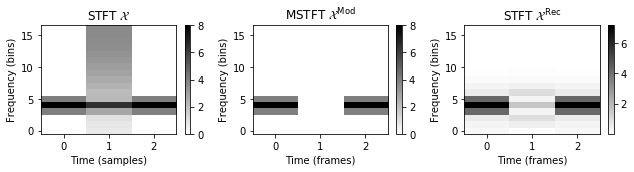

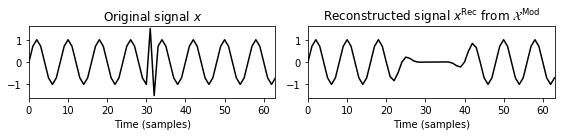

In [1]:
import os, sys
import numpy as np
import scipy.signal
import librosa
from matplotlib import pyplot as plt
sys.path.append('..')
import libfmp.b

%matplotlib inline

# Signal
L = 64
t = np.arange(L)/L
omega = 8
x = np.sin(2 * np.pi * omega * t)
x[31] = +1.5
x[32] = -1.5
N = 32
H = N//2
w_type = 'hann'
w = scipy.signal.get_window(w_type, N) 

X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=False)
plt.figure(figsize=(9,2.5))
ax = plt.subplot(1,3,1)
libfmp.b.plot_matrix(np.abs(X),ax=[ax], 
                xlabel='Time (samples)', ylabel='Frequency (bins)',                      
                title=r'STFT $\mathcal{X}$')

X_mod = X
X_mod[:,1]=0
ax = plt.subplot(1,3,2)
libfmp.b.plot_matrix(np.abs(X_mod),ax=[ax],
                xlabel='Time (frames)', ylabel='Frequency (bins)', 
                title=r'MSTFT $\mathcal{X}^\mathrm{Mod}$')

x_rec = librosa.istft(X_mod, hop_length=H, win_length=N, window='hann', center=False, length=L)
X_rec = librosa.stft(x_rec, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=False)
ax = plt.subplot(1,3,3)
libfmp.b.plot_matrix(np.abs(X_rec),ax=[ax], 
                xlabel='Time (frames)', ylabel='Frequency (bins)', 
                title=r'STFT $\mathcal{X}^\mathrm{Rec}$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.plot(x, 'k')
plt.xlim([0,L-1])
plt.ylim([-1.6, 1.6]) 
plt.title(r'Original signal $x$')
plt.xlabel('Time (samples)')

plt.subplot(1,2,2)
plt.plot(x_rec, 'k')
plt.xlim([0,L-1])
plt.ylim([-1.6, 1.6]) 
plt.title(r'Reconstructed signal $x^\mathrm{Rec}$ from $\mathcal{X}^\mathrm{Mod}$')
plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()

## Reconstruction as Optimization Problem

Our exampled illustrated that the STFT of the reconstructed signal $x^\mathrm{Rec}$ may not coincide with the specified MSTFT. More generally, one can show that, regardless of the reconstruction method, there may not exist a time-domain signal whose STFT matches a given MSTFT. Therefore, an important problem is to find ways for estimating a signal whose STFT is at least as close as possible to the MSTFT with regard to a suitably defined distance measure. This is exactly the problem that was tackled by Griffin and Lim in their seminal paper on [**Signal Estimation from Modified Short-Time Fourier Transform**](https://ieeexplore.ieee.org/document/1164317). Following this article, we now outline one possible procedure. To measure the distance between a given MSTFT $\mathcal{X}^\mathrm{Mod}$ and an STFT $\mathcal{X}'$ of a signal $x'$, we introduce the **mean square error** $\Delta(\mathcal{X}^\mathrm{Mod},\mathcal{X}')$ defined by 

\begin{equation}
   \Delta(\mathcal{X}^\mathrm{Mod},\mathcal{X}'):=\sum_{n\in\mathbb{Z}}\,\,\sum_{k\in[0:N-1]}
   |\mathcal{X}^\mathrm{Mod}(n,k)-\mathcal{X}'(n,k)|^2.
\end{equation}

The objective is to find the signal $x^\ast$ whose STFT $\mathcal{X}^\ast$ minimizes this error over all possible signals $x'$:

\begin{equation}
   x^\ast := \underset{x'}{\mathrm{argmin}} \Delta(\mathcal{X}^\mathrm{Mod},\mathcal{X}').
\end{equation}

Griffin and Lim showed that this optimization problem has an explicit solution given by

\begin{equation}
\label{eq:AudioDeco:HPS:SR:ErrSTFTMinSol}
   x^\ast(r) = \frac{\sum_{n\in\mathbb{Z}} w(r-nH)v_n(r-nH)}{\sum_{n\in\mathbb{Z}} w(r-nH)^2},
\end{equation}

where the signals $v_n$ are defined as at the beginning of this notebook. Note that this procedure is similar in nature to the previously described overlap&ndash;add techniques. The major difference is that, in the optimal solution, the signals $v_n$ are windowed with the analysis window before being overlaid and added. Furthermore, the additional windowing is compensated by normalizing with the sum of the squared windows. For further details and a discussion of alternative procedures, we refer to the original paper by Griffin and Lim. 

## Further Notes

* The function `librosa.istft` for computing the inverse STFT uses the optimal overlap&ndash;add strategy with the additional windowing. Note that when starting from a valid (unmodified) STFT, both overlap&ndash;add strategies yield the same solution with the mean square error being zero.

* Note that in the optimization, the mean square error is measured on the basis of the **complex-valued Fourier coefficients**. In their article, Griffin and Lim propose a second procedure that only considers the mean square error of the **magnitudes** of the MSTFT and the estimated STFT. For this problem, no closed-form solution exists. Instead an iterative optimization procedure is described&mdash;an approach that is often referred to as **Griffin&ndash;Lim Algorithm**.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>